In [ ]:
!pip install tsaug

In [ ]:
!pip install pycausalimpact

In [ ]:
import numpy as np
import pandas as pd
 
import os
import glob
 
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.collections as collections
 
import tensorflow as tf
import tensorflow.feature_column as fc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install pyriemann
!pip install mne
import pyriemann
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Constants
EEG_CHANNELS = ["Fz", "C3", "Cz", "C4", "CP1", "CPz", "CP2", "Pz"]
dir = "/content/drive/MyDrive/GTec/Dataset/locked in"

Load Data

In [ ]:
os.chdir(dir)
os.getcwd()

'/content/drive/MyDrive/GTec/Dataset/locked in'

In [ ]:
mat_files = glob.glob('*.mat')
mat_files

['P1_high1.mat',
 'P2_low1.mat',
 'P2_high1.mat',
 'P2_high2.mat',
 'P2_low2.mat',
 'P1_high2.mat',
 'P1_low1.mat',
 'P1_low2.mat']

In [ ]:
mat_file = spio.loadmat(mat_files[0])
keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
cleaned_mat_file = {i:mat_file[i] for i in mat_file if i in keys}
channel_data = pd.DataFrame(cleaned_mat_file["y"], columns=EEG_CHANNELS)
fs = pd.DataFrame(cleaned_mat_file["fs"])[0][0]
channel_data.head()
outputs = cleaned_mat_file["trig"]

In [ ]:
eeg_recordings = {}
for mat_file_name in mat_files:
  mat_file = spio.loadmat(mat_file_name)
  keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
  cleaned_mat_file = {i:mat_file[i] for i in mat_file if i in keys}
  channel_data = pd.DataFrame(cleaned_mat_file["y"], columns=EEG_CHANNELS)
  channel_data["output"] = cleaned_mat_file["trig"]
  channel_data["output"] = channel_data["output"].replace([-1], 3)
  channel_data.astype({"output": "int32"})
  eeg_recordings[mat_file_name] = channel_data

Distractor - 3
Non target - 1
Target - 2

In [ ]:
sample_data = eeg_recordings["P2_low2.mat"]
sample_data

,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz,output
0,-18.198307,-41.679142,-58.040730,-28.957844,-45.758099,-39.229214,-49.859024,-24.768824,0
1,-20.113195,-42.527195,-59.256149,-30.186872,-47.145695,-40.757290,-51.395859,-25.748331,0
2,-21.264162,-42.744385,-59.901157,-31.081549,-48.150112,-42.143810,-52.995609,-26.235826,0
3,-21.481592,-42.307217,-60.127342,-31.577698,-48.578995,-43.137711,-54.385029,-26.291319,0
4,-20.914345,-41.543095,-60.199566,-31.790014,-48.486229,-43.609638,-55.377396,-26.268978,0
...,...,...,...,...,...,...,...,...,...
39899,-22.427023,-7.066786,-8.480715,-11.711740,-3.986313,-10.272511,-16.349691,-12.297679,0
39900,-21.098677,-6.132523,-7.287198,-10.273462,-3.388305,-9.055482,-14.875256,-10.983068,0
39901,-19.748150,-4.906825,-5.996058,-8.878644,-2.713736,-7.944721,-13.645805,-10.435642,0
39902,-18.376886,-3.759302,-4.738688,-7.595037,-1.934436,-7.085990,-12.773139,-10.569434,0


In [ ]:
nrows = 8
ncols = 1
t = np.arange(0,sample_data['CP1'].shape[0]/fs,1/fs)
print(t)
fig, ax = plt.subplots(nrows, figsize=(50,35))
counter = 0
display(sample_data)
for i in range(8):
  try:
    channel = EEG_CHANNELS[counter]
    counter = counter + 1 
    ax[i].plot(t,sample_data[channel])
    ax[i].set_title(channel)   
    ax[i].set_xlabel("Time (s)")   
  except:
    continue

[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 1.55863281e+02
 1.55867188e+02 1.55871094e+02]


,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz,output
0,-18.198307,-41.679142,-58.040730,-28.957844,-45.758099,-39.229214,-49.859024,-24.768824,0
1,-20.113195,-42.527195,-59.256149,-30.186872,-47.145695,-40.757290,-51.395859,-25.748331,0
2,-21.264162,-42.744385,-59.901157,-31.081549,-48.150112,-42.143810,-52.995609,-26.235826,0
3,-21.481592,-42.307217,-60.127342,-31.577698,-48.578995,-43.137711,-54.385029,-26.291319,0
4,-20.914345,-41.543095,-60.199566,-31.790014,-48.486229,-43.609638,-55.377396,-26.268978,0
...,...,...,...,...,...,...,...,...,...
39899,-22.427023,-7.066786,-8.480715,-11.711740,-3.986313,-10.272511,-16.349691,-12.297679,0
39900,-21.098677,-6.132523,-7.287198,-10.273462,-3.388305,-9.055482,-14.875256,-10.983068,0
39901,-19.748150,-4.906825,-5.996058,-8.878644,-2.713736,-7.944721,-13.645805,-10.435642,0
39902,-18.376886,-3.759302,-4.738688,-7.595037,-1.934436,-7.085990,-12.773139,-10.569434,0


Power Spectrum

In [ ]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# np.fft.fft
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)
x = sample_data['CP1']
ps = np.abs(np.fft.fft(x))**2
plt.figure(figsize=(15,10))
plt.plot(freqs[idx], ps[idx])
plt.xlim(-20,20)
plt.title('Power spectrum (np.fft.fft)')

In [ ]:
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)
x = sample_data['CP1'] 
x = x - np.mean(x)
ps = np.abs(np.fft.fft(x))**2
plt.figure(figsize=(15,10))
plt.plot(freqs[idx], ps[idx])
plt.xlim(-20,20)
plt.title('Power spectrum (np.fft.fft)')

In [ ]:
sample_data.output.value_counts()

In [ ]:
t.size

In [ ]:
All_channels = np.zeros((8,t.size))
for i, ch in enumerate(EEG_CHANNELS):
  All_channels[i,:] = sample_data[ch]

In [ ]:
from tsaug.visualization import plot
plot(All_channels)

Segment

In [ ]:
# Initialize dict of dict
segmented_data_dict = {**dict.fromkeys(mat_files, {})}
augmented_data_dict = {**dict.fromkeys(mat_files, {})}
for mat_file in mat_files[0:]:
  df = eeg_recordings[mat_file]
  
  n_ch, n_sample = 8, 180
  n_output = len(df[df.output !=0])

  #output a segmented matrix  (number of segments x segment length x channels) for a mat file
  All_segs = np.empty((n_output, 180, 8))

  #initilaize y with length equal total no. of valid output 1,2,3
  y = np.zeros(n_output)

  prev_y = 0
  for output in [1,2,3]:
    
    output_df = df[df.output == output]
    n = len(output_df)

    # create x
    for i, sample_idx in enumerate(output_df.index.values):
      # print(sample_idx)
      # each segment is -100ms to 600ms (128 x 8 )
      #.loc end-index is inclusive, we want the sample right before 600ms mark
      segment = df.drop("output", axis=1).loc[sample_idx-26:
                                                sample_idx+153, :].to_numpy()
      # print(segment.shape)     
      # print(All_segs.shape)                                     
      All_segs[prev_y + i,] = segment

    # create y
    y[prev_y:
      prev_y + n] = output
    prev_y = prev_y + n
    # print(y)

  #save X,y as a dict of dict {matfile1: {X: arr, y: arr}, 
  segmented_data_dict[mat_file] = {
      "X": All_segs,
      "y": y
  }
  augmented_data_dict[mat_file] = {
       "X": All_segs,
      "y": y
  }
  print(mat_file)
  print(segmented_data_dict[mat_file]['X'].shape)
  print(segmented_data_dict[mat_file]['y'].shape)
  print("---")
  # break

Data Augmentation

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise
my_augmenter = (
    # random time warping 5 times in parallel
       Drift(max_drift=(0.1, 0.2)) @ 0.2  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
     + AddNoise(scale=(0.01, 0.05)) @ 0.5  
 )

In [ ]:
for i in range(5):
  for mat_file in mat_files[0:]:
    aug_data = 0
    new_labels = 0
    ind = ((segmented_data_dict[mat_file]['y'] == 1) | (segmented_data_dict[mat_file]['y'] == 2))
    req_data = segmented_data_dict[mat_file]['X'][ind]
    req_data = np.swapaxes(req_data, 2, 1)
    new_labels = segmented_data_dict[mat_file]['y'][ind]
    aug_data = my_augmenter.augment(req_data)
    aug_data = np.swapaxes(aug_data,1,2)
    augmented_data_dict[mat_file]['X'] = np.vstack((augmented_data_dict[mat_file]['X'], aug_data))
    augmented_data_dict[mat_file]['y'] = np.hstack((augmented_data_dict[mat_file]['y'], new_labels))

In [ ]:
augmented_data_dict['P1_high1.mat']['X'].shape

In [ ]:
plot(np.swapaxes(augmented_data_dict['P1_high1.mat']['X'][-5],0,1))

In [ ]:
P2_X = np.empty((1,180,8))
P2_Y = np.empty((1,))
for mat_file in ["P2_high2.mat","P2_high1.mat","P2_low2.mat","P2_low1.mat"]:
  X = augmented_data_dict[mat_file]['X']
  y = augmented_data_dict[mat_file]['y']
  P2_X = np.vstack((P2_X, X))
  P2_Y =  np.hstack((P2_Y,y))
P2_X = P2_X[1:,:,:]
P2_Y = P2_Y[1:]

In [ ]:
P2_X.shape

In [ ]:
P2_Y.shape

In [ ]:
P2_X[1]

In [ ]:
np.unique(P2_Y)

In [ ]:
for i in range(P2_X.shape[0]):
  P2_X[i,:,:] = P2_X[i,:,:] - np.average(P2_X[i,0:26,:],axis=0)

Plot Random Signal Windows

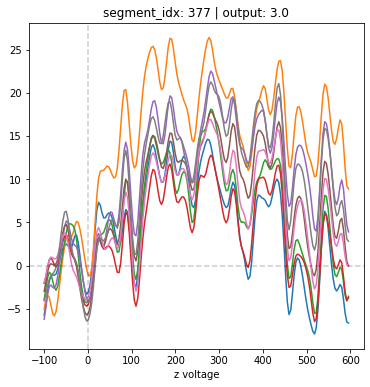

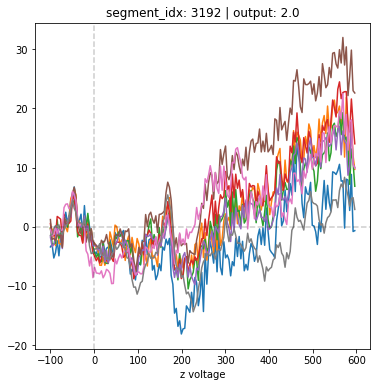

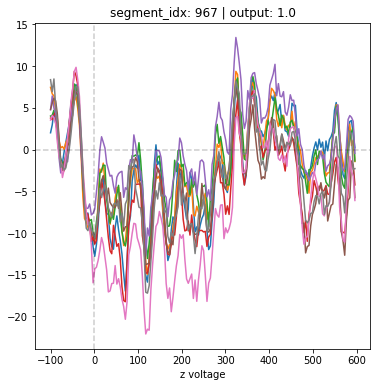

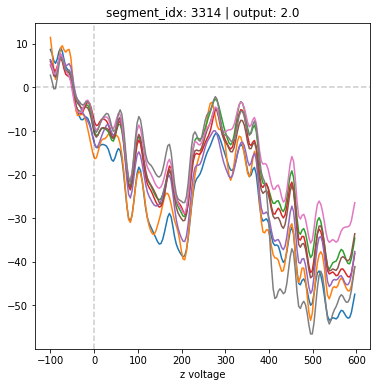

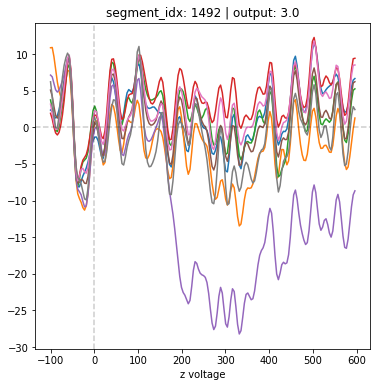

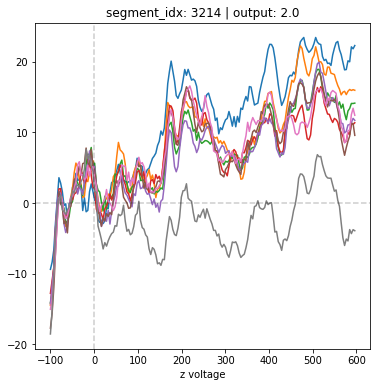

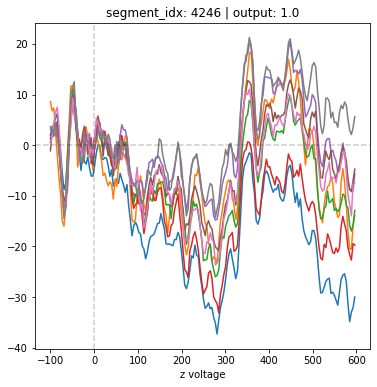

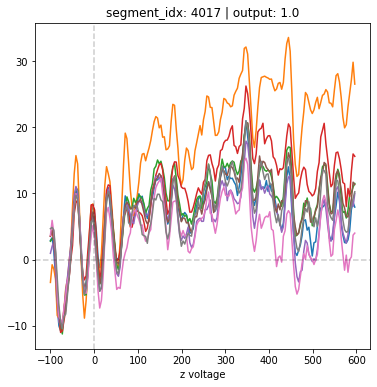

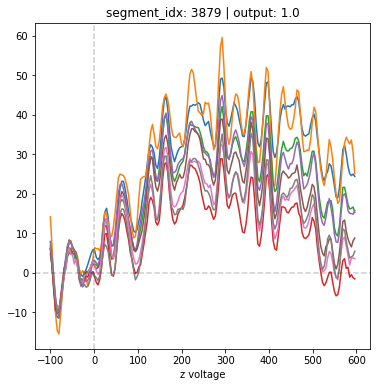

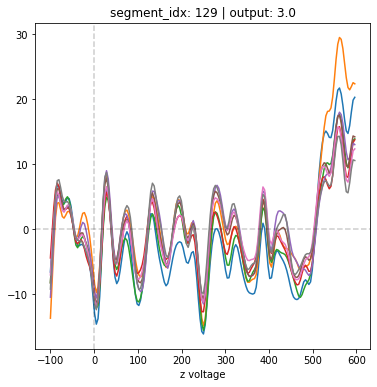

In [ ]:
import random
x_plot_arr = P2_X #np.concatenate([X_train, X_test], axis=0)
for _ in range(10):
  seg = random.choice(np.arange(len(x_plot_arr)))
  output = P2_Y[seg]

  plt.figure(figsize=(6,6))
  for i in x_plot_arr[seg,:,:].T:
    # print(i.shape)
    #26 samples: 100s
    plt.plot(np.arange(-100, 600, 700/180), i)
  plt.axvline(0, c='k', alpha=0.2, linestyle="--")
  plt.axhline(0, c='k', alpha=0.2, linestyle="--")
  plt.title("segment_idx: {} | output: {}".format(seg, output))
  plt.xlabel('ms')
  plt.xlabel('z voltage')

Plot Class Average

(180, 8)
(180, 8)
(180, 8)


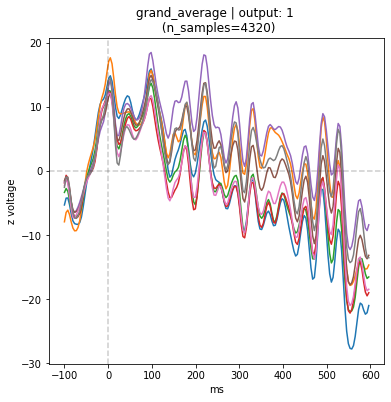

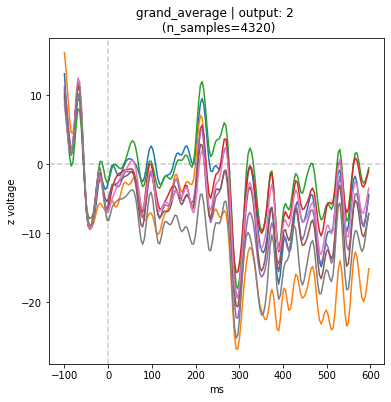

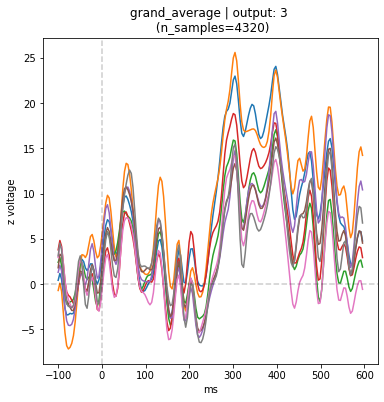

In [ ]:
x_plot_arr, y_plot_arr = P2_X, P2_Y
for output in [1, 2,3]:
  X_average = np.average(x_plot_arr[np.argwhere(y_plot_arr==output)][0], axis=0)
  print(X_average.shape)
  seg = "grand_average"
  plt.figure(figsize=(6,6))
    #26 samples: 100s
  for ch in np.arange(8):
    plt.plot(np.arange(-100, 600, 700/180), X_average.T[ch])
  plt.axvline(0, c='k', alpha=0.2, linestyle="--")
  plt.axhline(0, c='k', alpha=0.2, linestyle="--")
  plt.title("{} | output: {} \n (n_samples={})".format(seg, output, len(x_plot_arr)))
  plt.xlabel('ms')
  plt.ylabel('z voltage')

In [ ]:
P2_X_avg = np.mean(P2_X, axis = 2)

In [ ]:
P2_Y_new = np.expand_dims(P2_Y, axis = -1)

In [ ]:
P2_X_1 = P2_X_avg[P2_Y == 1]
P2_X_2 = P2_X_avg[P2_Y == 2]
P2_X_3 = P2_X_avg[P2_Y == 3]

In [ ]:
P2_X_1.shape

(1440, 180)

In [ ]:
P2_X_2.shape

(1440, 180)

In [ ]:
P2_X_3.shape

(1440, 180)

In [ ]:
P2_Y_1 = P2_Y[P2_Y == 1]
P2_Y_2 = P2_Y[P2_Y == 2]
P2_Y_3 = P2_Y[P2_Y == 3]

In [ ]:
P2_Y_1.shape

(1440,)

In [ ]:
P2_Y_2.shape

(1440,)

In [ ]:
P2_Y_3.shape

(1440,)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
P2_1_train, P2_1_val = train_test_split(P2_X_1, train_size=0.8)
P2_2_train, P2_2_val = train_test_split(P2_X_2, train_size=0.8)
P2_3_train, P2_3_val = train_test_split(P2_X_3, train_size=0.8)

In [ ]:
P2_1_val, P2_1_test = train_test_split(P2_1_val, test_size=0.5)
P2_2_val, P2_2_test = train_test_split(P2_2_val, test_size=0.5)
P2_3_val, P2_3_test = train_test_split(P2_3_val, test_size=0.5)

In [ ]:
P2_1_train.shape

(1152, 180)

In [ ]:
P2_1_val.shape

(144, 180)

In [ ]:
P2_1_test.shape

(144, 180)

In [ ]:
from os import path
from google.colab import files

import librosa.display


In [ ]:
def signal_image(batch, set, num):
  for i in range(batch.shape[0]):
    fig, ax = plt.subplots(figsize = (20,20))
    ax.specgram(batch[i], Fs=512, cmap="rainbow")

    # Set the title of the plot, xlabel and ylabel
    # and display using show() function
    plt.axis('off')
    plt.savefig(f"/content/drive/MyDrive/GTec/Dataset/Patient 2/{set}/{num}/{num}_{i}.png", bbox_inches='tight')
    # files.download('test.png')

In [ ]:
# signal_image(P2_1_train,'Train',1)

In [ ]:
# signal_image(P2_2_train,'Train',2)

In [ ]:
signal_image(P2_3_train,'Train',3)

In [ ]:
# signal_image(P2_1_val,'Validation',1)

In [ ]:
# signal_image(P2_2_val,'Validation',2)

In [ ]:
# signal_image(P2_3_val,'Validation',3)

In [ ]:
# signal_image(P2_1_test,'Test',1)

In [ ]:
# signal_image(P2_2_test,'Test',2)

In [ ]:
# signal_image(P2_3_test,'Test',3)

In [ ]:
# fig, ax = plt.subplots(figsize = (20,20))
# ax.specgram(P2_1_train[2], Fs=512, cmap="rainbow")

# # Set the title of the plot, xlabel and ylabel
# # and display using show() function
# plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')
# files.download('test.png')